In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.io as pio
import mne
import json
import glob
import os
from tqdm import tqdm
import time
from datetime import timedelta
from braindecode.datasets import BaseConcatDataset
from mne_features.feature_extraction import FeatureExtractor
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
from pyriemann.utils.distance import distance_riemann, distance_euclid, distance_logeuclid
from pyriemann.utils.mean import mean_riemann, mean_euclid, mean_logeuclid
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment, self_subject_label_alignment, relabel_dataset
from collections import defaultdict
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore') 

/home/administrator/.local/lib/python3.8/site-packages/mne_features/mock_numba.py:12: UserWarning: Numba needs NumPy 1.20 or less. Your code will be slower.
  warn('{}. Your code will be slower.'.format(err))


In [26]:
%%time
# fmt: off
# subjects = [
#     # 'BN001', 'BN002', 'BN003',
#     # 'BN004', 'BN099', 'BN100',
#     'K001', 'K002', 'K003',
#     'K004', 'K005', 'K006',
#     'K007', 'K008', 'K009',
#     'K010', 'K011', 'K012',
#     'K013', 'K014', 'K015',
#     'K016', 'K017', 'K018',
#     'K019', 'K020', 'K021',
#     'K022', 'K023', 'K024',
#     'K025', 'K026', 'K027',
#     'K028', 'K299', 'K300',
#     'K301', 'K302', 'K303',
#     'K304', 'K305', 'K306',
#     'K307', 'K308', 'K309',
#     'K310', 'K311', 'K312',
#     'K313', 'K314', 'K315',
#     'K316', 'K317', 
#     # 'K318',
#     'K319', 'K320', 'K321',
#     'K322', 'K323', 'K324',
#     'K325', 'K326', 'K327',
#     'K328', 'K329', 'K330',
#     'K331', 'K332', 'K333',
#     'K334', 'K335', 'K336',
#     'K337', 'K338', 'K339',
#     'K340', 'K342', 'K343',
#     'K344', 'K350', 'K351',
#     'K352', 'K353', 'K354',
#     'K355', 
#     # 'K355 (1)', 
#     'K356',
#     'K357', 'K358', 'K359',
#     'K360', 'K361', 'K362',
#     'K363', 'K364', 'K365',
#     'K366', 'K367', 'K368',
#     'K369', 'K370', 'K371',
#     'K372', 'K373', 'K374',
#     'K375',
# ]

subjects = [
    'K001', 'K002', 'K003', 'K004', 'K005', 
    'K006', 'K007', 'K008', 'K009', 'K010', 
    'K011', 'K012', 'K013', 'K015', 'K016', 
    'K017', 'K018', 'K021', 'K022', 'K023', 
    'K024', 'K025', 'K026', 'K027', 'K028', 
    'K300', 'K301', 'K302', 'K303', 'K304', 
    'K305', 'K306', 'K307', 'K308', 'K309', 
    'K310', 'K311', 'K312', 'K313', 'K314', 
    'K315', 'K316', 'K319', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K326', 
    'K327', 'K328', 'K329', 'K330', 'K331', 
    'K332', 'K333', 'K334', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K342', 'K343', 
    'K344', 'K350', 'K351', 'K352', 'K353', 
    'K354', 'K355', 'K357', 'K358', 'K359', 
    'K360', 'K361', 'K362', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    # "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    "há miệng_Thinking": "há miệng",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

max_duration = {  # seconds
    # "nâng tay trái": 10,
    # "nâng tay phải": 10,
    # "nâng chân trái": 10,
    # "nâng chân phải": 10,
    # "gật đầu": 10,
    # "lắc đầu": 10,
    # "rest": 10,
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

moving_standardize = False  # @param {"type": "boolean"}

ds = load_data(
    "../data/DataVIN/Official",  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = [
#     'ALS01_t1', 'ALS01_t2', 'ALS01_t3', 'ALS01_t4', 'ALS01_t5', 'ALS01_t6',
#     'ALS02_t1', 'ALS02_t2', 'ALS02_t3', 'ALS02_t4', 
# ]

# als_ds = load_data(
#     "../data/DataVIN/ALS/als-patients",  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     max_duration=max_duration,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=moving_standardize,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = als_ds
# subjects = als_subjects

# ds = BaseConcatDataset([ds, als_ds])
# subjects.extend(als_subjects)

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "ALS01_t2":
#         _ds_info["subject"] = "ALS01_t1"
#     elif _ds_info["subject"] == "ALS01_t4":
#         _ds_info["subject"] = "ALS01_t3"
#     elif _ds_info["subject"] == "ALS01_t6":
#         _ds_info["subject"] = "ALS01_t5"

# list_of_ds = list()
# for _ds in ds.datasets:
#     if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
#         continue
#     list_of_ds.append(_ds)
    
# ds = BaseConcatDataset(list_of_ds)
# del list_of_ds
        
ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 32 channels


trial: 100%|██████████| 3374/3374 [00:11<00:00, 286.68it/s]


loaded 90 subjects - 32489 epochs
CPU times: user 1min 25s, sys: 12.6 s, total: 1min 38s
Wall time: 1min 37s


,subject,scenario,event,onset,label,label_idx,trial,split,epochs
0,K001,nâng tay trái,Thinking,6.7125,nâng tay trái,6,0,train,9
1,K001,nâng tay trái,Resting,13.1479,rest,0,0,train,10
2,K001,nâng tay trái,Resting,32.7215,rest,0,1,train,5
3,K001,nâng tay trái,Thinking,37.0182,nâng tay trái,6,1,train,10
4,K001,nâng tay trái,Thinking,62.7771,nâng tay trái,6,2,train,10
...,...,...,...,...,...,...,...,...,...
3369,K375,lắc đầu,Thinking,6.0130,lắc đầu,2,0,train,10
3370,K375,lắc đầu,Thinking,24.6901,lắc đầu,2,1,train,9
3371,K375,lắc đầu,Resting,40.4353,rest,0,0,train,5
3372,K375,lắc đầu,Thinking,44.9166,lắc đầu,2,2,train,10


gật đầu: 4.5s-10.5s
lắc đầu: 4.5s-15.0s
nâng chân phải: 4.5s-12.0s
nâng chân trái: 4.5s-15.5s
nâng tay phải: 5.0s-10.0s
nâng tay trái: 4.5s-15.0s
rest: 4.0s-17.0s


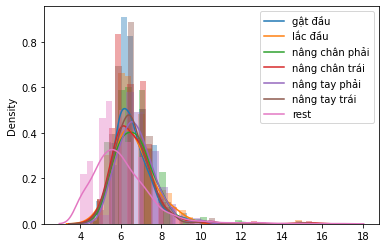

In [27]:
labels = sorted(list(set(ds_info["label"])))

for label in labels:
    du = list()
    for _, r in ds_info[ds_info["label"] == label].iterrows():
        du.append((r["epochs"] - 1) * window_stride_duration + window_duration)

    print(f"{label}: {min(du)}s-{max(du)}s")
    sb.distplot(du)

plt.legend(labels)

In [3]:
ds.datasets[0].windows.event_id

{'rest': 0,
 'gật đầu': 1,
 'lắc đầu': 2,
 'nâng chân phải': 3,
 'nâng chân trái': 4,
 'nâng tay phải': 5,
 'nâng tay trái': 6}

In [16]:
ea_ds1 = deepcopy(ds)
euclidean_alignment(ea_ds1, target_subject=None, metric="euclid")

subject: 100%|██████████| 90/90 [00:07<00:00, 12.18it/s]


In [23]:
ea_ds2 = deepcopy(ds)
euclidean_alignment(ea_ds2, target_subject=None, metric="riemann")

subject: 100%|██████████| 93/93 [02:10<00:00,  1.40s/it]


In [17]:
ss = [
    'K300', 'K301', 'K302', 'K303', 'K304', 
    'K305', 'K306', 'K307', 'K308', 'K309', 
    # 'K310', 'K311', 'K312', 'K313', 'K314',
]
le = LabelEncoder()
le.fit(ss)

LabelEncoder()

In [23]:
X = list()
Y = list()
S = list()
for i in ds_info[ds_info["subject"].isin(ss)].index:
    X.append(ea_ds1.datasets[i].windows.get_data())
    Y.extend(ea_ds1.datasets[i].y)
    S.extend([ea_ds1.datasets[i].description["subject"]] * len(ea_ds1.datasets[i].y))
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)
S = le.transform(S)

X.shape

(4979, 32, 256)

In [24]:
C = np.stack([np.cov(x, rowvar=True) for x in X])
feat = TangentSpace(metric="riemann").fit_transform(C)
feat2d = TSNE(n_components=2).fit_transform(feat)

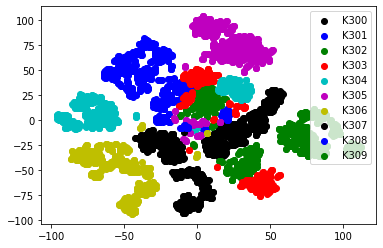

In [25]:
colors = "kbgrcmy"

for i, c in enumerate(range(len(le.classes_))):
    idx = np.where(S == c)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i % len(colors)])
    
plt.legend(le.classes_)

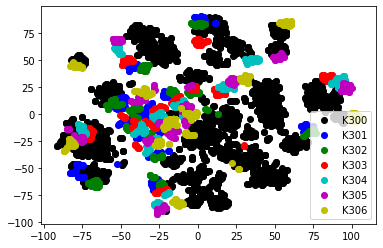

In [37]:
colors = "kbgrcmy"

# for i, c in enumerate(range(len(le.classes_))):
#     idx = np.where(S == c)[0]
for i, c in enumerate(np.unique(Y)):
    idx = np.where(Y == c)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i % len(colors)])
    
plt.legend(le.classes_)

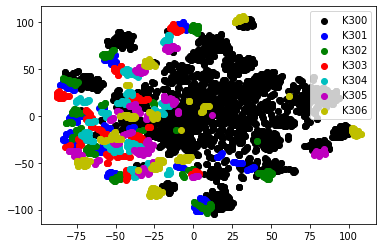

In [40]:
colors = "kbgrcmy"

# for i, c in enumerate(range(len(le.classes_))):
#     idx = np.where(S == c)[0]
for i, c in enumerate(np.unique(Y)):
    idx = np.where(Y == c)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i % len(colors)])
    
plt.legend(le.classes_)

In [40]:
X = list()
Y = list()

for i in ds_info[ds_info["subject"] == "K309"].index:
    X.append(ds.datasets[i].windows.get_data())
    Y.extend(ds.datasets[i].y)
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)

X.shape

(516, 28, 256)

In [56]:
C = np.stack([np.cov(x, rowvar=True) for x in X])
Cm1 = mean_riemann(C)
Cm2 = mean_logeuclid(C)
Cm3 = mean_euclid(C)
C = np.concatenate((C, Cm1[None], Cm2[None], Cm3[None]), axis=0)
feat = TangentSpace(metric="riemann").fit_transform(C)
feat2d = TSNE(n_components=2).fit_transform(feat)

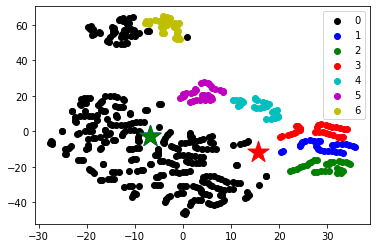

In [57]:
colors = "kbgrcmy"

for i, c in enumerate(np.unique(Y)):
    idx = np.where(Y == c)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i])
    

plt.scatter(feat2d[-3, 0], feat2d[-3, 1], marker='*', c='b', s=500)
plt.scatter(feat2d[-2, 0], feat2d[-2, 1], marker='*', c='g', s=500)
plt.scatter(feat2d[-1, 0], feat2d[-1, 1], marker='*', c='r', s=500)
    
plt.legend(np.unique(Y))

In [16]:
X = list()
Y = list()
S = list()
for i in ds_info[ds_info["subject"].isin(["K309"])].index:
    X.append(ds.datasets[i].windows.get_data())
    Y.extend(ds.datasets[i].y)
    S.extend([ds.datasets[i].description["subject"]] * len(ds.datasets[i].y))
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)
le = LabelEncoder()
S = le.fit_transform(S)

X = (X - X.mean(axis=-1, keepdims=True)) / X.std(axis=-1, keepdims=True)
X.shape

(516, 32, 256)

In [10]:
epochs = mne.concatenate_epochs([ds.datasets[i].windows for i in ds_info[(ds_info["subject"] == "K309") & (ds_info["label"] == "nâng tay trái")].index])

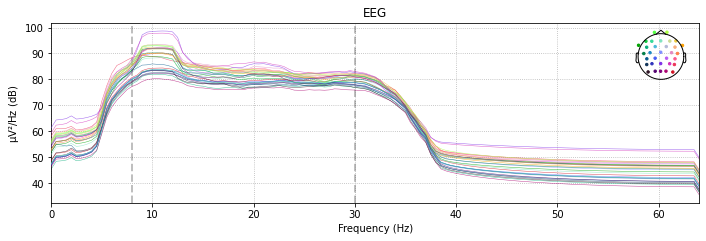

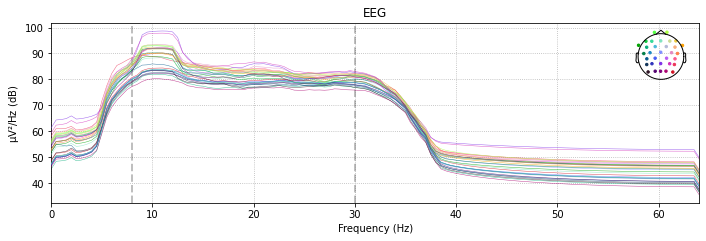

In [11]:
epochs.plot_psd()

In [7]:
X = list()
Y = list()
for i in ds_info[ds_info["subject"] == "K309"].index:
    X.append(ds.datasets[i].windows.get_data())
    Y.extend(ds.datasets[i].y)
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)

X.shape

(516, 32, 256)

In [8]:
C = np.stack([np.cov(x, rowvar=True) for x in X])
feat = TangentSpace(metric="riemann").fit_transform(C)
feat2d = TSNE(n_components=2).fit_transform(feat)

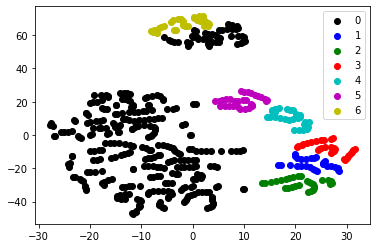

In [9]:
colors = "kbgrcmy"

for i, c in enumerate(np.unique(Y)):
    idx = np.where(Y == c)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i])
    
plt.legend(np.unique(Y))

In [110]:
ea_ds = deepcopy(ds)

# for _ds in ea_ds.datasets:
#     if _ds.description["subject"] in ["ALS01_t2"]:
#         _ds.description["subject"] = "ALS01_t1"

# label_alignment(ea_ds, target_subject="ALS01_t1", skip_subjects=["ALS01_t2", "ALS01_t3", "ALS01_t4", "ALS01_t5", "ALS01_t6"])
euclidean_alignment(ea_ds, target_subject=None)

subject: 100%|██████████| 93/93 [00:04<00:00, 20.70it/s]


In [61]:
X = list()
Y = list()
S = list()
for _ds in ea_ds.datasets:
    if not _ds.description["subject"].startswith("ALS"):
        continue
    
    X.append(_ds.windows.get_data())
    Y.extend(_ds.y)
    S.extend([_ds.description["subject"]] * len(_ds.y))
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)
se = LabelEncoder()
S = se.fit_transform(S)

X.shape, np.bincount(Y)

((3477, 32, 256), array([572, 591, 578, 580, 576, 580]))

In [62]:
C = np.stack([np.cov(x, rowvar=True) for x in X])
feat = TangentSpace(metric="riemann").fit_transform(C)
feat2d = TSNE(n_components=2).fit_transform(feat)

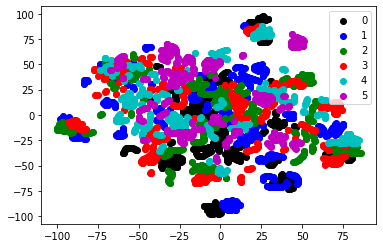

In [63]:
colors = "kbgrcmy"

for i, c in enumerate(np.unique(Y)):
    idx = np.where(Y == c)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i])
    
plt.legend(np.unique(Y))

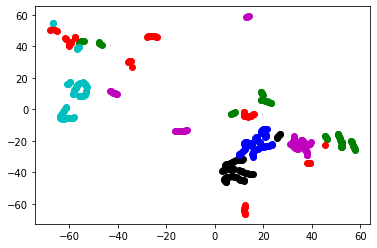

In [64]:
for i, c in enumerate(range(6)):
    idx = np.where((Y == c) & (S == 3))[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i])

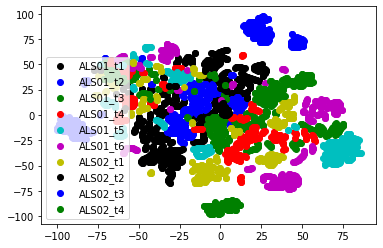

In [65]:
for i, c in enumerate(np.unique(S)):
    idx = np.where(S == c)[0]
    plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', c=colors[i % len(colors)])
    
plt.legend(se.classes_)

In [78]:
dist

,subject 1,subject 2,distance
0,ALS01_t1,ALS01_t2,5.005351
1,ALS01_t1,ALS01_t3,5.992454
2,ALS01_t1,ALS01_t4,5.102559
3,ALS01_t1,ALS01_t5,6.009719
4,ALS01_t1,ALS01_t6,5.499343
...,...,...,...
8551,K375,K370,9.042595
8552,K375,K371,10.929019
8553,K375,K372,8.906672
8554,K375,K373,9.397377


In [122]:
# for subject in [*(f"ALS01_t{i}" for i in range(1,7)), *(f"ALS02_t{i}" for i in range(1,5))]:
# for subject in sorted(ds_info["subject"].unique()):
for subject in {'K309', 'K311', 'K312', 
    'K313', 'K315', 'K316', 
    'K321', 'K322', 'K323', 
    'K325', 'K326', 'K327', 
    'K328', 'K332', 'K334', 
    'K335', 'K336', 'K337', 
    'K339', 'K354', 'K358', 
    'K359', 'K360', 'K362', 
    'K365', 'K366', 'K368', 
    'K370', 'K372', 'K373', 
    'K374', 'K375',}:
    for t in range(1):
        Xtrain = list()
        Ytrain = list()
        Xvalid = list()
        Yvalid = list()
        # for i in ds_info[ds_info["subject"] == subject].index:
        #     if ds.datasets[i].description["trial"] == t:
        #         Xvalid.append(ea_ds.datasets[i].windows.get_data())
        #         Yvalid.extend(ea_ds.datasets[i].y)
        #     else:
        #         Xtrain.append(ea_ds.datasets[i].windows.get_data())
        #         Ytrain.extend(ea_ds.datasets[i].y)
        
        # top_subjects = set(dist[dist["subject 1"] == subject].sort_values("distance")[:30]["subject 2"])
        # print(f"subject {subject} --> top_subjects: {top_subjects}")
        
        # for _ds in ea_ds.datasets:
        #     if _ds.description["subject"] == subject:
        #         Xvalid.append(_ds.windows.get_data())
        #         Yvalid.extend(_ds.y)
        #     # elif _ds.description["subject"].startswith(subject.split("_")[0]):
        #     elif _ds.description["subject"] in top_subjects:
        #         Xtrain.append(_ds.windows.get_data())
        #         Ytrain.extend(_ds.y)
        
#         exp_ds = list()
#         for _ds in ds.datasets:
#             if _ds.description["subject"] == subject or _ds.description["subject"] in top_subjects:
#                 exp_ds.append(deepcopy(_ds))
                
#         exp_ds = BaseConcatDataset(exp_ds)
#         # euclidean_alignment(exp_ds, target_subject=subject, progress_bar=False)
        
#         for _ds in exp_ds.datasets:
#             if _ds.description["subject"] == subject:
#                 Xvalid.append(_ds.windows.get_data())
#                 Yvalid.extend(_ds.y)
#             else:
#                 Xtrain.append(_ds.windows.get_data())
#                 Ytrain.extend(_ds.y)

        for i in ds_info[ds_info["subject"] == subject].index:
            if ds.datasets[i].description["event"] == "Thinking":
                Xvalid.append(ds.datasets[i].windows.get_data())
                Yvalid.extend(ds.datasets[i].y)
            elif ds.datasets[i].description["event"] == "Thinking and Acting":
                Xtrain.append(ds.datasets[i].windows.get_data())
                Ytrain.extend(ds.datasets[i].y)

        if len(Xtrain) == 0:
            continue
                
        Xtrain = np.concatenate(Xtrain, axis=0)
        Ytrain = np.array(Ytrain, dtype=int)
        Xvalid = np.concatenate(Xvalid, axis=0)
        Yvalid = np.array(Yvalid, dtype=int)
        
        # Xtrain = (Xtrain - Xtrain.mean(axis=-1, keepdims=True)) / Xtrain.std(axis=-1, keepdims=True)
        # Xvalid = (Xvalid - Xvalid.mean(axis=-1, keepdims=True)) / Xvalid.std(axis=-1, keepdims=True)

        # -----------riemann manifold------
        clf = make_pipeline(
            Covariances("cov"),
            FgMDM(metric=dict(mean="riemann", distance="riemann"), n_jobs=-1),
            # TSclassifier(
            #     metric="riemann",
            #     clf=SVC(
            #         C=0.1,
            #         kernel="rbf",
            #         # tol=1e-7,
            #         max_iter=100000,
            #         class_weight="balanced",
            #         random_state=42,
            #     ),
            #     # clf=LinearDiscriminantAnalysis(
            #     #     solver="lsqr",
            #     #     shrinkage="auto",
            #     #     n_components=None,
            #     #     # tol=1e-7,
            #     #     covariance_estimator=None,
            #     # ),
            # ),
        )

        clf.fit(Xtrain, Ytrain)

        Ypred = clf.predict(Xvalid)

#         # ------------raw psd-------------
#         fe = FeatureExtractor(sfreq=128.0, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

#         clf = SVC(
#             C=1.0,
#             kernel="rbf",
#             # tol=1e-7,
#             max_iter=100000,
#             class_weight="balanced",
#             random_state=42,
#         )
            
#         clf.fit(fe.fit_transform(Xtrain, Ytrain), Ytrain)
        
#         Ypred = clf.predict(fe.transform(Xvalid))
        
#         max_nc = 0
#         max_acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
#         max_confusion_matrix = metrics.confusion_matrix(Yvalid, Ypred)

#         # -----------csp psd--------------
#         csp = mne.decoding.CSP(n_components=32, reg=None, log=None, rank="full", transform_into='csp_space')
    
#         Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
#         Xvalid_csp = csp.transform(Xvalid)
        
#         # Xtrain_csp = (Xtrain_csp - Xtrain_csp.mean(axis=-1, keepdims=True)) / Xtrain_csp.std(axis=-1, keepdims=True)
#         # Xvalid_csp = (Xvalid_csp - Xvalid_csp.mean(axis=-1, keepdims=True)) / Xvalid_csp.std(axis=-1, keepdims=True)
        
#         bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28,32)]
#         params = dict({
#             'pow_freq_bands__log': True,
#             'pow_freq_bands__normalize': False,
#             'pow_freq_bands__freq_bands': bands,
#         })
        
#         for nc in range(1, 33):
#             fe = FeatureExtractor(sfreq=128.0, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

#             clf = SVC(
#                 C=0.1,
#                 kernel="rbf",
#                 # tol=1e-7,
#                 max_iter=100000,
#                 class_weight="balanced",
#                 random_state=42,
#             )
            
#             clf.fit(fe.fit_transform(Xtrain_csp[:, :nc], Ytrain), Ytrain)
            
#             Ypred = clf.predict(fe.transform(Xvalid_csp[:, :nc]))
            
#             acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
#             if acc >= max_acc:
#                 max_nc = nc
#                 max_acc = acc
#                 max_confusion_matrix = metrics.confusion_matrix(Yvalid, Ypred)

        print(f"subject {subject}/trial {t} - acc: {metrics.balanced_accuracy_score(Yvalid, Ypred)}")
        print(metrics.confusion_matrix(Yvalid, Ypred))
        # print(f"subject {subject}/nc {max_nc} - acc: {max_acc}")
        # print(max_confusion_matrix)

subject K374/trial 0 - acc: 0.398989898989899
[[ 1  1 11 20  0  0]
 [ 0  0 10 25  0  0]
 [ 0  0 12 21  0  0]
 [ 0  0  0 32  0  0]
 [ 0  0  0 34  0  0]
 [ 0  0  0  0  0 30]]
subject K311/trial 0 - acc: 0.668682268385503
[[38  2  0  3  0  0]
 [18 13  0  0  0  0]
 [ 0  0  1 35  0  0]
 [ 0  0  0 28  0  0]
 [ 0  0  0  2 35  0]
 [ 0  0  0  0  9 25]]
subject K362/trial 0 - acc: 0.6946229209387105
[[36  0  0  0  0  0]
 [38  0  0  0  0  0]
 [ 1  0 30  0  2  0]
 [ 1  0  6 12 19  0]
 [ 0  0  2  0 33  0]
 [ 0  0  0  0  0 34]]
subject K325/trial 0 - acc: 0.5954349110797452
[[24  0  7  0  0  0]
 [31  3  0  0  0  0]
 [10  0 13  0  6  0]
 [ 0  0  7 11 24  0]
 [ 0  0  0  0 27  0]
 [ 0  0  0  0  0 26]]
subject K323/trial 0 - acc: 0.7938461538461539
[[ 0 21  9  0  0  0]
 [ 0 25  0  0  0  0]
 [ 0  0 25  0  0  0]
 [ 0  1  0 24  1  0]
 [ 0  0  2  2 21  0]
 [ 0  0  0  0  0 27]]
subject K316/trial 0 - acc: 0.6052361659572286
[[ 0  8 22  4  0  0]
 [ 0 18 16  0  0  0]
 [ 0  0 36  1  0  0]
 [ 0  0 17  4 10  0]
 

In [94]:
X = list()
Y = list()
S = list()
for _ds in ds.datasets:
    X.append(_ds.windows.get_data())
    Y.extend(_ds.y)
    S.extend([int(_ds.description["subject"][-1])] * len(_ds.y))
for _ds in ea_ds.datasets:
    X.append(_ds.windows.get_data())
    Y.extend(_ds.y)
    S.extend([int(_ds.description["subject"][-1])] * len(_ds.y))
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)
S = np.array(S, dtype=int)

X.shape, np.bincount(Y)

((6550, 32, 256), array([2330,  688,  732,  702,  702,  696,  700]))

In [95]:
C = np.stack([np.cov(x, rowvar=True) for x in X])
feat = TangentSpace(metric="riemann").fit_transform(C)
feat2d = TSNE(n_components=2).fit_transform(feat)

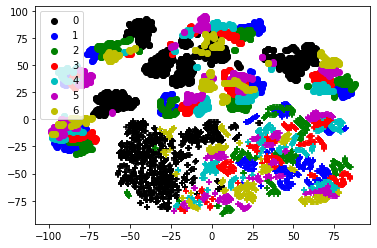

In [96]:
colors = "kbgrcmy"

n = len(X) // 2

Y0 = Y[:n]
feat2d0 = feat2d[:n]
for i, c in enumerate(np.unique(Y0)):
    idx = np.where(Y0 == c)[0]
    plt.scatter(feat2d0[idx, 0], feat2d0[idx, 1], marker='o', c=colors[i])
    
Y0 = Y[n:]
feat2d0 = feat2d[n:]
for i, c in enumerate(np.unique(Y0)):
    idx = np.where(Y0 == c)[0]
    plt.scatter(feat2d0[idx, 0], feat2d0[idx, 1], marker='+', c=colors[i])
    
plt.legend(np.unique(Y))

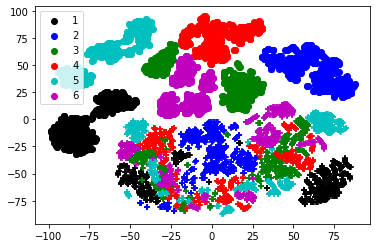

In [97]:
S0 = S[:n]
feat2d0 = feat2d[:n]
for i, c in enumerate(np.unique(S0)):
    idx = np.where(S0 == c)[0]
    plt.scatter(feat2d0[idx, 0], feat2d0[idx, 1], marker='o', c=colors[i])
    
S0 = S[n:]
feat2d0 = feat2d[n:]
for i, c in enumerate(np.unique(S0)):
    idx = np.where(S0 == c)[0]
    plt.scatter(feat2d0[idx, 0], feat2d0[idx, 1], marker='+', c=colors[i])
    
plt.legend(np.unique(S))

In [123]:
S = sorted(ds_info["subject"].unique())
C = list()

for s in S:
    x = list()
    for i in ds_info[ds_info["subject"] == s].index:
        x.append(ds.datasets[i].windows.get_data())
        
    x = np.concatenate(x, axis=0)
    c = np.stack([np.cov(xi, rowvar=True) for xi in x])
    c = mean_riemann(c)
    # c = mean_euclid(c)
    C.append(c)

In [124]:
dist = list()
for i, si in enumerate(S):
    for j, sj in enumerate(S):
        if i == j:
            continue
            
        dist.append((si, sj, distance_riemann(C[i], C[j])))

dist = pd.DataFrame(dist, columns=["subject 1", "subject 2", "distance"])
dist

,subject 1,subject 2,distance
0,ALS01_t1,ALS01_t2,5.005351
1,ALS01_t1,ALS01_t3,5.992454
2,ALS01_t1,ALS01_t4,5.102559
3,ALS01_t1,ALS01_t5,6.009719
4,ALS01_t1,ALS01_t6,5.499343
...,...,...,...
8551,K375,K370,8.157569
8552,K375,K371,9.515069
8553,K375,K372,7.729986
8554,K375,K373,8.290179


In [125]:
dist[dist["subject 1"] == "K309"].sort_values("distance")[:10]

,subject 1,subject 2,distance
3598,K309,K001,7.235959
3600,K309,K003,7.410338
3623,K309,K305,7.490477
3617,K309,K027,7.524182
3666,K309,K360,7.587375
3618,K309,K300,7.667930
3619,K309,K301,7.769642
3615,K309,K024,7.792466
3606,K309,K010,7.825915
3603,K309,K006,7.854350


In [75]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dist.loc[dist.groupby(by='subject 1')['distance'].idxmin()])

     subject 1 subject 2  distance
0     ALS01_t1  ALS01_t2  5.005351
92    ALS01_t2  ALS01_t1  5.005351
188   ALS01_t3  ALS01_t6  3.561384
278   ALS01_t4  ALS01_t3  3.624724
371   ALS01_t5  ALS01_t4  4.418887
462   ALS01_t6  ALS01_t3  3.561384
558   ALS02_t1  ALS02_t2  5.277269
650   ALS02_t2  ALS02_t1  5.277269
744   ALS02_t3  ALS02_t4  7.319639
830   ALS02_t4  ALS01_t3  7.272079
950       K001      K301  4.136771
1039      K002      K026  5.004397
1129      K003      K023  4.676163
1206      K004      K001  4.831624
1298      K005      K001  6.079205
1390      K006      K001  6.655333
1492      K008      K015  6.958023
1594      K009      K301  7.286877
1676      K010      K015  5.494753
1837      K012      K373  8.817445
1870      K013      K301  4.893325
1950      K015      K010  5.494753
2034      K016      K001  6.666771
2128      K017      K003  5.969349
2233      K021      K023  7.763951
2325      K022      K023  7.517837
2404      K023      K003  4.676163
2494      K024      

In [121]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(dist.loc[dist.groupby(by='subject 1')['distance'].idxmin()])

     subject 1 subject 2  distance
2     ALS01_t1  ALS01_t4  4.240609
92    ALS01_t2  ALS01_t1  4.590849
188   ALS01_t3  ALS01_t6  3.301375
278   ALS01_t4  ALS01_t3  3.362373
371   ALS01_t5  ALS01_t4  4.143103
462   ALS01_t6  ALS01_t3  3.301375
558   ALS02_t1  ALS02_t2  5.168169
650   ALS02_t2  ALS02_t1  5.168169
744   ALS02_t3  ALS02_t4  7.319241
830   ALS02_t4  ALS01_t3  7.212041
950       K001      K301  3.952343
1039      K002      K026  4.334464
1134      K003      K301  4.966586
1226      K004      K301  4.439724
1317      K005      K300  5.558967
1409      K006      K300  6.289191
1492      K008      K015  5.724336
1594      K009      K301  6.796885
1676      K010      K015  5.376971
1837      K012      K373  7.701643
1870      K013      K301  4.985876
1993      K015      K334  5.211939
2034      K016      K001  6.122560
2128      K017      K003  5.571245
2286      K021      K360  6.191306
2325      K022      K023  6.301495
2404      K023      K003  5.384370
2494      K024      

In [50]:
class CSP_PSD(object):
    def __init__(self, n_components=32, sfreq=128.0):
        self.csp = mne.decoding.CSP(n_components=n_components, reg=None, log=None, rank="full", transform_into='csp_space')
        
        bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28,32)]
        params = dict({
            'pow_freq_bands__log': True,
            'pow_freq_bands__normalize': False,
            'pow_freq_bands__freq_bands': bands,
        })
        self.fe = FeatureExtractor(sfreq=sfreq, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)
        
        self.clf = SVC(
            C=1.0,
            kernel="rbf",
            # tol=1e-7,
            max_iter=100000,
            class_weight="balanced",
            random_state=42,
        )
        
    def fit(self, Xtrain, Ytrain):
        Xtrain = self.csp.fit_transform(Xtrain, Ytrain)
        Xtrain = self.fe.fit_transform(Xtrain, Ytrain)
        self.clf.fit(Xtrain, Ytrain)
        
    def predict(self, X):
        X = self.csp.transform(X)
        X = self.fe.transform(X)
        return self.clf.predict(X)

In [130]:
results = list()
for subject in sorted(ds_info["subject"].unique()):
    if subject.startswith("ALS"):
        continue
    
    Xtrain = list()
    Ytrain = list()
    for i in ds_info[ds_info["subject"] == subject].index:
        Xtrain.append(ds.datasets[i].windows.get_data())
        Ytrain.extend(ds.datasets[i].y)
            
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    
    clf = make_pipeline(
        Covariances("cov"),
        FgMDM(metric=dict(mean="riemann", distance="riemann"), n_jobs=-1),
        # TSclassifier(
        #     metric="riemann",
        #     clf=SVC(
        #         C=0.1,
        #         kernel="rbf",
        #         # tol=1e-7,
        #         max_iter=100000,
        #         class_weight="balanced",
        #         random_state=42,
        #     ),
        #     # clf=LinearDiscriminantAnalysis(
        #     #     solver="lsqr",
        #     #     shrinkage="auto",
        #     #     n_components=None,
        #     #     # tol=1e-7,
        #     #     covariance_estimator=None,
        #     # ),
        # ),
    )

    clf.fit(Xtrain, Ytrain)
    
    # clf = dict()
    # for nc in range(1, 33):
    #     clf[nc] = CSP_PSD(nc)
    #     clf[nc].fit(Xtrain, Ytrain)
    
    for target_subject in sorted(ds_info["subject"].unique()):
        if target_subject.startswith("ALS"):
            continue
        if target_subject == subject:
            continue
            
        Xvalid = list()
        Yvalid = list()
        for i in ds_info[ds_info["subject"] == target_subject].index:
            Xvalid.append(ds.datasets[i].windows.get_data())
            Yvalid.extend(ds.datasets[i].y)

        Xvalid = np.concatenate(Xvalid, axis=0)
        Yvalid = np.array(Yvalid, dtype=int)
        
        Ypred = clf.predict(Xvalid)
        
#         max_acc = 0
#         max_nc = 0
#         for nc in range(1, 33):
#             Ypred = clf[nc].predict(Xvalid)
#             _acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
#             if _acc >= max_acc:
#                 max_acc = _acc
#                 max_nc = nc
                
#         Ypred = clf[max_nc].predict(Xvalid)
        
        # print(f"subject {subject} ----> subject {target_subject}\tacc: {metrics.balanced_accuracy_score(Yvalid, Ypred)}")
        # print(metrics.balanced_accuracy_score(Yvalid, Ypred))
        # print(metrics.confusion_matrix(Yvalid, Ypred))
        
        results.append((subject, target_subject, metrics.balanced_accuracy_score(Yvalid, Ypred)))

In [131]:
results = pd.DataFrame(results, columns=["subject", "target_subject", "acc"])
results

,subject,target_subject,acc
0,K001,K002,0.402116
1,K001,K003,0.333333
2,K001,K004,0.404255
3,K001,K005,0.342723
4,K001,K006,0.275657
...,...,...,...
6801,K375,K370,0.169192
6802,K375,K371,0.166667
6803,K375,K372,0.166667
6804,K375,K373,0.166667


In [132]:
results[results["target_subject"] == "K309"].sort_values("acc", ascending=False)[:10]

,subject,target_subject,acc
4375,K335,K309,0.426403
3227,K321,K309,0.342232
5605,K359,K309,0.325649
6671,K374,K309,0.310307
5277,K354,K309,0.310149
356,K005,K309,0.278347
1012,K016,K309,0.276810
848,K013,K309,0.276042
930,K015,K309,0.275956
3965,K330,K309,0.274294


In [29]:
Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()

for _ds in ea_ds.datasets:
    # if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
    #     continue
    # if _ds.description["trial"] == 2:
    if _ds.description["subject"] in ["ALS01_t3", "ALS01_t4", "ALS01_t5", "ALS01_t6"]:
        Xvalid.append(_ds.windows.get_data())
        Yvalid.extend(_ds.y)
    else:
        Xtrain.append(_ds.windows.get_data())
        Ytrain.extend(_ds.y)
    
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)

Xtrain.shape, np.bincount(Ytrain), Xvalid.shape, np.bincount(Yvalid)

((14262, 32, 256),
 array([2658, 2077, 2097, 2672, 2098, 2660]),
 (1422, 32, 256),
 array([233, 253, 233, 235, 232, 236]))

In [30]:
%%time
clf = make_pipeline(
    Covariances("cov"),
    TSclassifier(
        metric="riemann",
        clf=SVC(
            C=0.1,
            kernel="rbf",
            # tol=1e-7,
            max_iter=100000,
            class_weight="balanced",
            random_state=42,
        ),
        # clf=LinearDiscriminantAnalysis(
        #     solver="lsqr",
        #     shrinkage="auto",
        #     n_components=None,
        #     # tol=1e-7,
        #     covariance_estimator=None,
        # ),
    ),
)

clf.fit(Xtrain, Ytrain)

Ypred = clf.predict(Xvalid)
print(metrics.balanced_accuracy_score(Yvalid, Ypred))

# print(metrics.confusion_matrix(clf.predict(Xtrain), Ytrain))
print(metrics.confusion_matrix(Yvalid, Ypred))

0.1988051038858253
[[112 121   0   0   0   0]
 [ 81 154   0   0  18   0]
 [ 39 177   0   0  17   0]
 [ 45 168   0   0  22   0]
 [  9 199   0   0  24   0]
 [ 46 174   0   0  16   0]]
CPU times: user 5min 50s, sys: 3min 55s, total: 9min 45s
Wall time: 2min 43s


In [31]:
%%time
csp = mne.decoding.CSP(n_components=32, reg=None, log=None, rank="full", transform_into='csp_space')

Xtrain_csp = csp.fit_transform(Xtrain, Ytrain)
Xvalid_csp = csp.transform(Xvalid)

CPU times: user 23.4 s, sys: 12.9 s, total: 36.3 s
Wall time: 12.3 s


In [32]:
%%time
bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28,32)]
# bands = [(8,12), (10,14), (14,18), (18,22), (22,26), (26,30)]
# bands = [(4,8), (8,12), (12,16), (16,20), (20,24), (24,28), (28,32), (32,36)]

params = dict({
    'pow_freq_bands__log': True,
    'pow_freq_bands__normalize': False,
    'pow_freq_bands__freq_bands': bands,
})

max_acc = 0

fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

Xtrain_bp = fe.fit_transform(Xtrain)
Xvalid_bp = fe.transform(Xvalid)

# ------------csv--------------
clf = SVC(
    C=0.1,
    kernel="rbf",
    # tol=1e-7,
    max_iter=100000,
    class_weight="balanced",
    random_state=42,
)
# clf=LinearDiscriminantAnalysis(
#     solver="lsqr",
#     shrinkage="auto",
#     n_components=None,
#     # tol=1e-7,
#     covariance_estimator=None,
# )

clf.fit(Xtrain_bp, Ytrain)

Ypred = clf.predict(Xvalid_bp)
acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
if acc >= max_acc:
    print(f"\033[91mraw - acc: {acc}\033[0m")
    # print(metrics.confusion_matrix(clf.predict(Xtrain_bp), Ytrain))
    print(metrics.confusion_matrix(Yvalid, Ypred))
    max_acc = acc
else:
    print(f"raw - acc: {acc}")

for nc in range(1, 33):
    fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'], params=params, n_jobs=-1)

    Xtrain_bp = fe.fit_transform(Xtrain_csp[:, :nc])
    Xvalid_bp = fe.transform(Xvalid_csp[:, :nc])

    # ------------csv--------------
    clf = SVC(
        C=0.1,
        kernel="rbf",
        # tol=1e-7,
        max_iter=100000,
        class_weight="balanced",
        random_state=42,
    )
    # clf=LinearDiscriminantAnalysis(
    #     solver="lsqr",
    #     shrinkage="auto",
    #     n_components=None,
    #     # tol=1e-7,
    #     covariance_estimator=None,
    # )

    clf.fit(Xtrain_bp, Ytrain)

    Ypred = clf.predict(Xvalid_bp)
    acc = metrics.balanced_accuracy_score(Yvalid, Ypred)
    if acc >= max_acc:
        print(f"\033[91mn_components: {nc} - acc: {acc}\033[0m")
        # print(metrics.confusion_matrix(clf.predict(Xtrain_bp), Ytrain))
        print(metrics.confusion_matrix(Yvalid, Ypred))
        max_acc = acc
    else:
        print(f"n_components: {nc} - acc: {acc}")

raw - acc: 0.205394695533381
[[ 18  23   9  15 132  36]
 [ 28  25   9  26  98  67]
 [ 11  12  13   7 153  37]
 [ 25   9  16  20 116  49]
 [ 11  26   8   7 118  62]
 [  9  13   4  11 103  96]]
n_components: 1 - acc: 0.16969952385347364
n_components: 2 - acc: 0.16982170885433576
n_components: 3 - acc: 0.16987825490826935
n_components: 4 - acc: 0.1639383195643692
n_components: 5 - acc: 0.145043455642448
n_components: 6 - acc: 0.14943425673039407
n_components: 7 - acc: 0.11846681029364366
n_components: 8 - acc: 0.14518574597734463
n_components: 9 - acc: 0.16461417797671754
n_components: 10 - acc: 0.16498404279070153
n_components: 11 - acc: 0.1650472124701714
n_components: 12 - acc: 0.16665354594931722
n_components: 13 - acc: 0.17070250690188563
n_components: 14 - acc: 0.17412474404250297
n_components: 15 - acc: 0.17335897813041332
n_components: 16 - acc: 0.18286436979665585
n_components: 17 - acc: 0.16534513026109535
n_components: 18 - acc: 0.16582969385008062
n_components: 19 - acc: 0.165

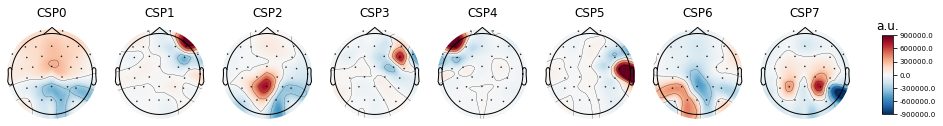

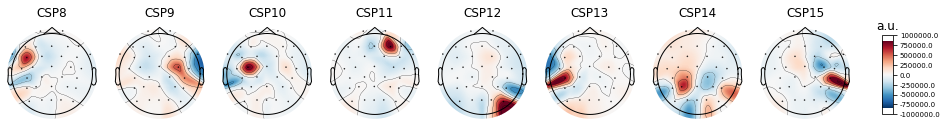

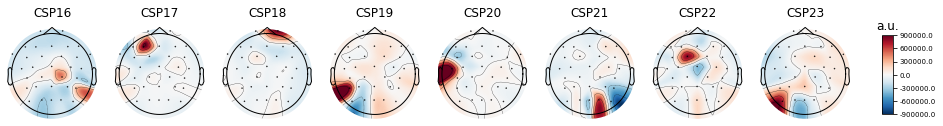

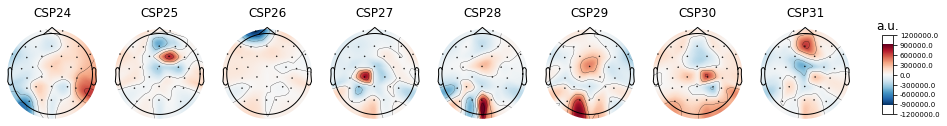

In [89]:
for i in range(0, 32, 8):
    csp.plot_patterns(ds.datasets[0].windows.info, components=list(range(i, min(i + 8, 32))))

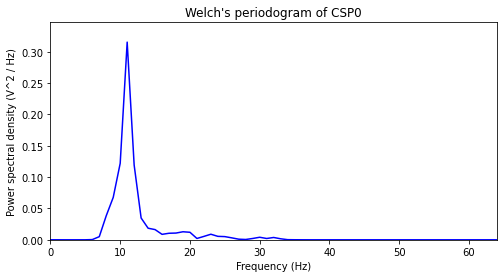

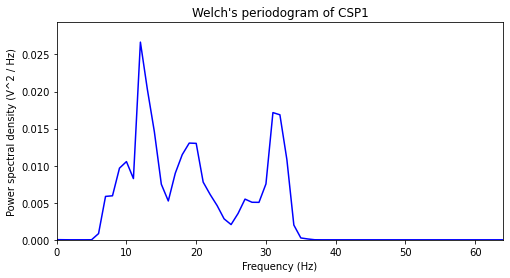

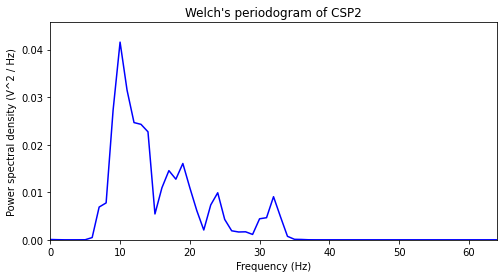

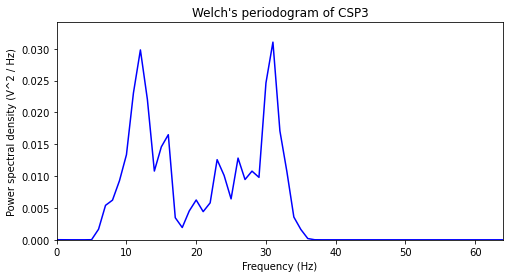

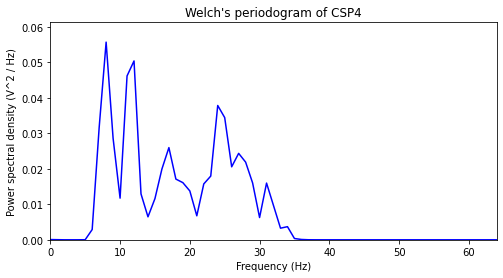

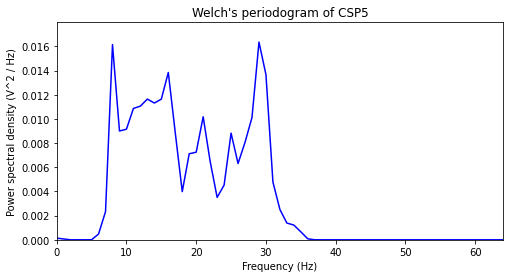

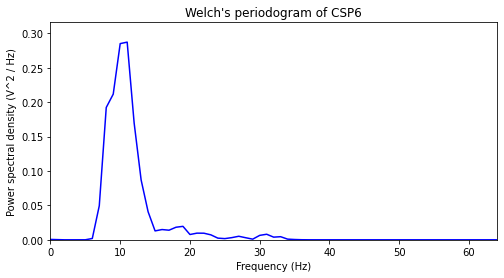

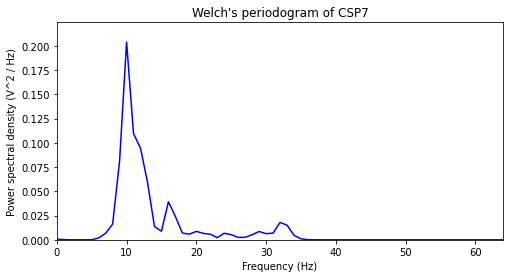

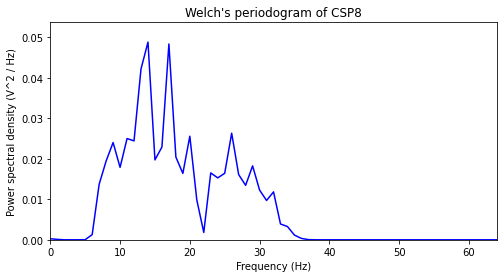

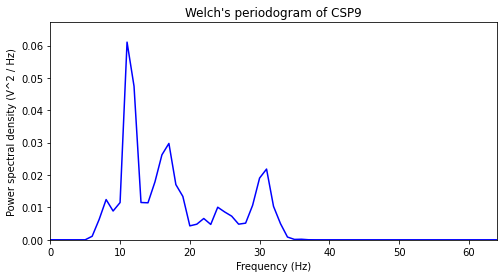

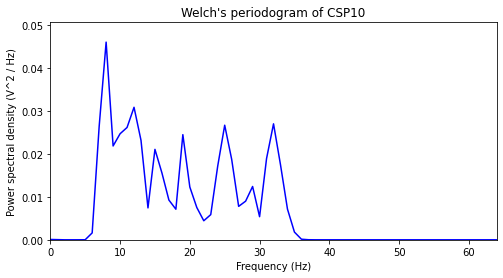

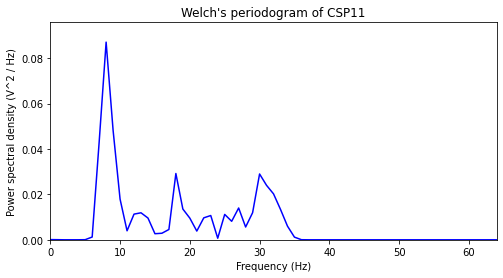

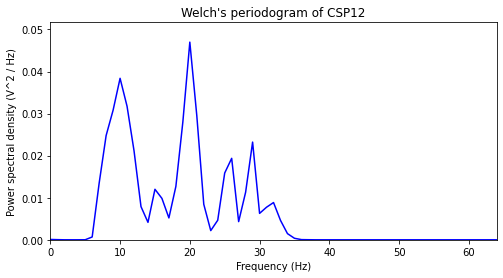

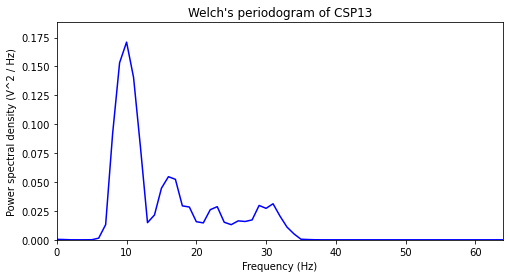

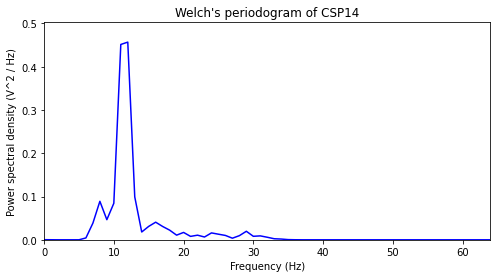

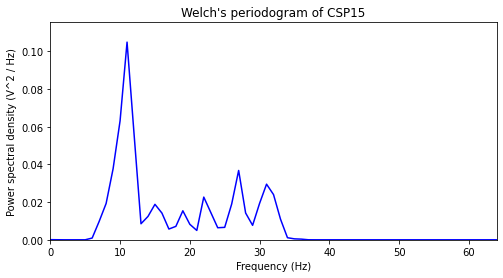

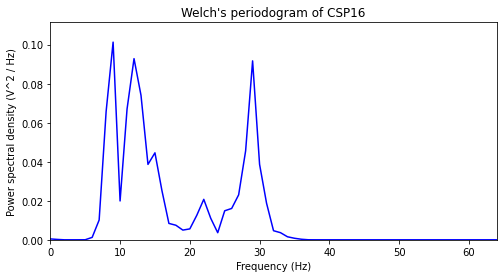

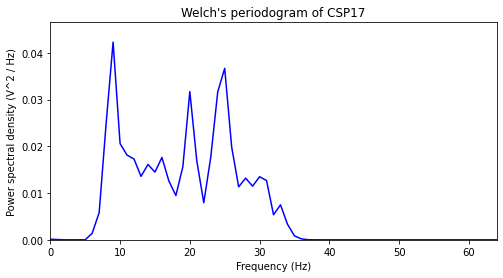

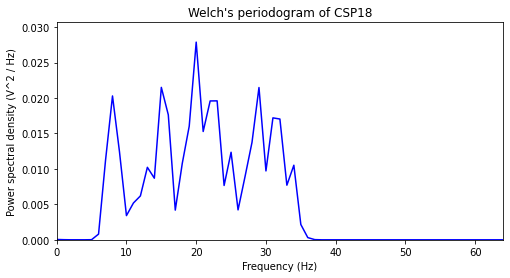

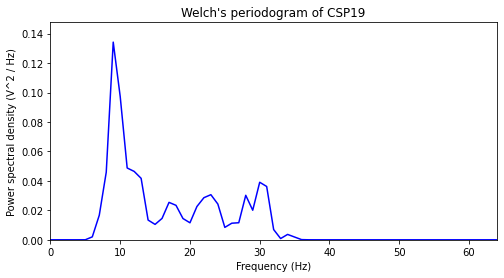

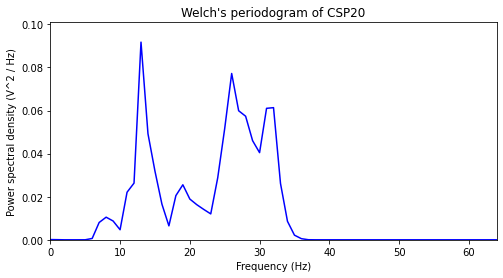

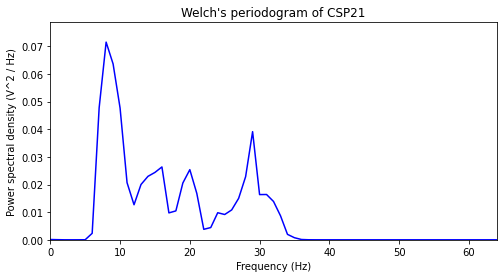

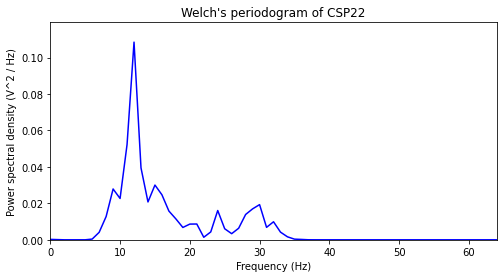

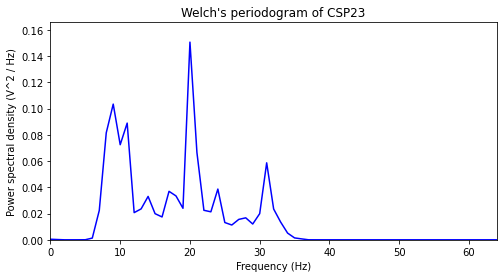

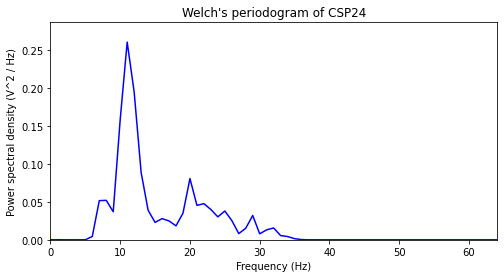

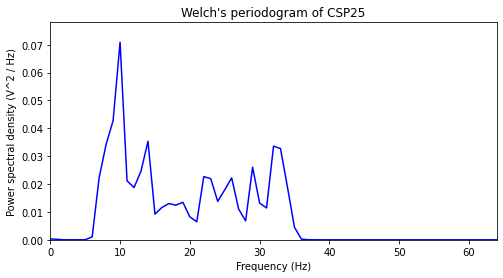

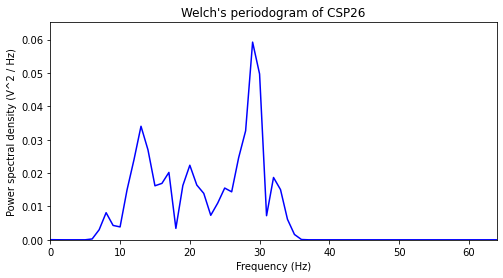

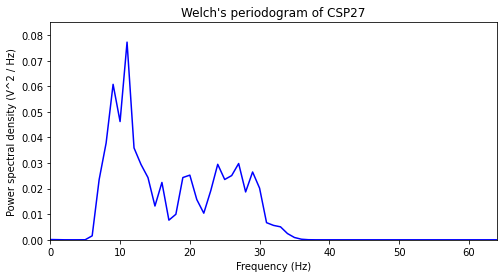

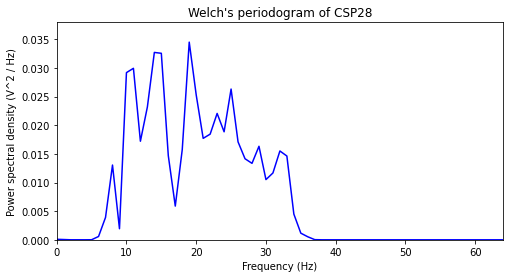

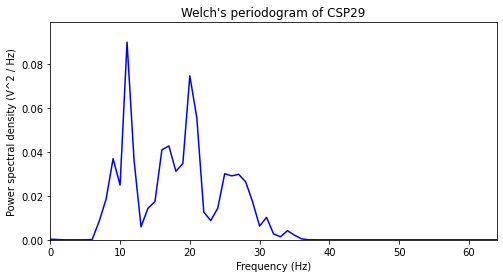

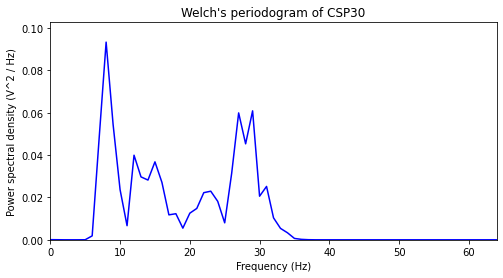

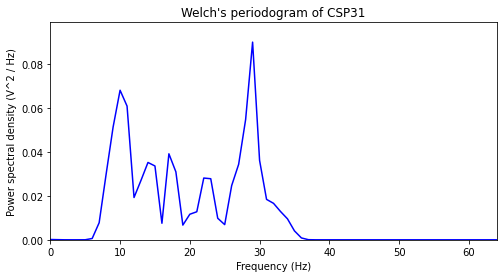

In [90]:
for i, x in enumerate(Xtrain_csp[np.where(Ytrain == 1)[0]][0]):
    freqs, psd = signal.welch(x, fs=128.0, nperseg=128, noverlap=64, nfft=None)

    # Plot the power spectrum
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, psd, color='b')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.ylim([0, psd.max() * 1.1])
    plt.title(f"Welch's periodogram of CSP{i}")
    plt.xlim([0, freqs.max()])

In [91]:
Ctrain = np.stack([np.cov(x, rowvar=True) for x in Xtrain])
Ctrain.shape

(2696, 32, 32)

<AxesSubplot:>

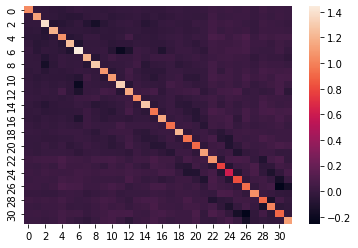

In [95]:
sb.heatmap(Ctrain[np.where(Ytrain == 0)[0]].mean(axis=0))

<AxesSubplot:>

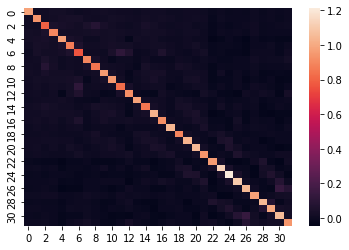

In [93]:
sb.heatmap(Ctrain[np.where(Ytrain != 0)[0]].mean(axis=0))